<a href="https://colab.research.google.com/github/BorisAbramovich/pose_estimation/blob/master/pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from scipy.io import loadmat
from PIL import Image, ImageDraw


In [0]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

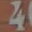

[4]


In [62]:
train['y'][train['y']==10]=0

#for i in range(300):
#  im=train['X'][:,:,:,i]
#  img = Image.fromarray(im, 'RGB')
#  display(img)
#  print(train['y'][i])
i=102
image = train['X'][:,:,:,i]
display(Image.fromarray(image))
print(train['y'][i])

In [0]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess

In [0]:
#files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']
files = ['val2017.zip', 'annotations_trainval2017.zip']

In [0]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)
# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

In [0]:
def getbbox_rect(bbox):
    return [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1]+bbox[3]]

import itertools
def chunked_iterable(iterable, size):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, size))
        if not chunk:
            break
        yield chunk
def id_to_filename(id, prefix = 'val2017/'):
  return prefix + format(id, '012d') + '.jpg'
def crop_and_size_image(annotations, target_size = (256,192), dataset_path = 'val2017/'):
  id = annotations['image_id']
  bbox = annotations['bbox']

  img = Image.open(id_to_filename(id, dataset_path))
  img = img.crop(getbbox_rect(bbox))
  return img.resize(target_size)

def recompute_keypoimts(annotations, target_size = (256,192)):
  bbox = annotations['bbox']
  keypoints = annotations['keypoints']
  return list(itertools.chain.from_iterable([(((point[0] - bbox[0])*target_size[0]/bbox[2], (point[1] - bbox[1])*target_size[1]/bbox[3], point[2])) for point in chunked_iterable(keypoints, 3)]))

def draw_points_on_image(image, points, point_names):
  drw=ImageDraw.Draw(image)
  for i,(x,y,v) in enumerate(chunked_iterable(points, 3)):
    if v!=0:
      drw.ellipse([x-1,y-1,x+1, y+1])
      drw.text((x,y), point_names[i])


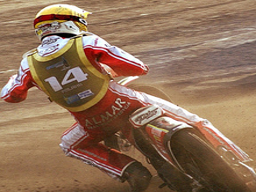

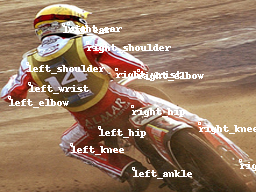

In [65]:
import json
j=1001
person_keypoints = json.load(open('annotations/person_keypoints_val2017.json'))
image = crop_and_size_image(person_keypoints['annotations'][j], (256,192), 'val2017/')
display(image)
points = recompute_keypoimts(person_keypoints['annotations'][j])
point_names = person_keypoints['categories'][0]['keypoints']
draw_points_on_image(image, points, point_names)
display(image)

